In [1]:
# conda activate chronocell

import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
# import anndata as ad

sys.path.append(os.path.abspath("../../code"))

from protein_from_RNA import *

# sys.path.append("/mnt/lareaulab/reliscu/programs/FGP_2024")

# import Chronocell
# from Chronocell.inference import Trajectory
# from Chronocell.mixtures import PoissonMixtureSS
# from Chronocell.utils import *
# from Chronocell.plotting import *
# from Chronocell.models.two_species_ss import get_Y

In [2]:
random_seed = 666

In [3]:
# Splicing rate
beta_mu = 2
beta_sd = 0.5

# Transcription rate
alpha_mu = np.log(2) # 2
alpha_sd = 1

# Translation rate
transl_rate_mu = np.log(100)
transl_rate_sd = 1

# mRNA degradation rate
rna_median_half_life = 9
gamma_rate = np.log(2) / rna_median_half_life
gamma_mu = np.log(gamma_rate) # Median of lognormal
gamma_sd = 0.5

# Protein degradation rate
protein_median_half_life = 46
deg_rate = np.log(2) / protein_median_half_life
deg_rate_mu = np.log(deg_rate) # Median of lognormal
deg_rate_sd = 1.5

# # # Read depth
# rd_mu = 0.25
# rd_var = 1/64

In [ ]:
# Simulate data

n = 2000 # No. cells per lineage
p = 500 # No. genes
topo = np.array([[0, 1, 2], [0, 1, 3]])
tau = (0, 10, 24)

theta = get_RNA_params(topo, p, alpha_mu, alpha_sd, beta_mu, beta_sd, gamma_mu, gamma_sd, random_seed=random_seed)
phi = get_protein_params(p, transl_rate_mu, transl_rate_sd, deg_rate_mu, deg_rate_sd, random_seed=random_seed)

In [ ]:
# Simulate RNA counts

Y_observed, Y, theta, rd, true_t, true_l = simulate_RNA(topo, tau, theta, n, random_seed=random_seed)

# Simulate protein counts

P_observed, P = simulate_protein_from_RNA(Y, topo, true_t, true_l, phi, random_seed=random_seed)

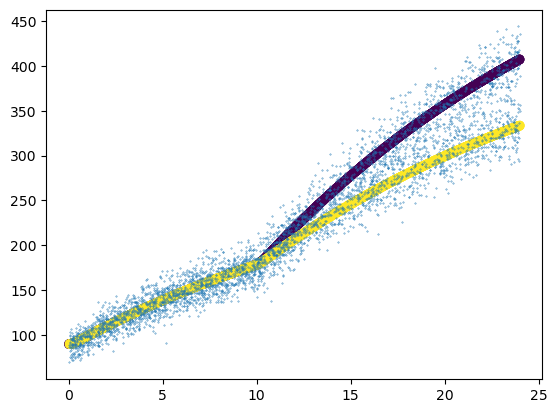

In [ ]:
idx = 0
plt.scatter(true_t, Y[:, idx, 1], c=true_l)
plt.scatter(true_t, Y_observed[:, idx, 1], s=.1)

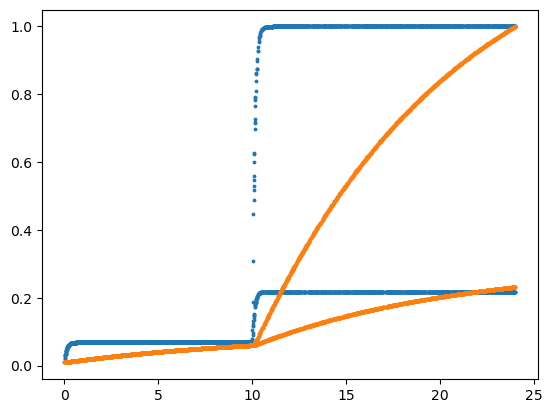

In [18]:
plt.scatter(true_t, Y[:, idx, 0]/np.max(Y[:, idx, 0]), s=3)
plt.scatter(true_t, Y[:, idx, 1]/np.max(Y[:, idx, 1]), s=3)

In [35]:
np.random.seed(random_seed)
    
L = len(topo) # No. lineages
n = Y.shape[0] # No. cells
p = Y.shape[1] # No. genes

y0 = Y[0, :, 1] # RNA levels per gene at state 0
ss_rate = (phi[:,0] / phi[:,-1]) # Steady-state protein production rate
p0 = phi[:,0] * y0 # Initial protein abundance assuming steady-state

In [36]:
# Protein production paramters:
transl_rate = phi[:,0].T
deg_rate = phi[:,-1].reshape((1, -1))

P = np.zeros((n*L, p))

l = 0


In [56]:
np.unique(true_l, return_counts=True)

(array([0, 1]), array([2000, 2000]))

In [58]:
true_t[true_l == l]

np.float64(0.003039606342350787)

In [ ]:
true_l == l

False

In [50]:
t_l = true_t[true_l == l].reshape((-1, 1)) # Time points/cells in lineage l     
y_l = Y[l*n:(l+1)*n, :, 1] # Counts from cells in lineage l
p_l = p0 * np.exp(-deg_rate * t_l) # Pre-existing protein that has not yet degraded for each cell in lineage l

In [53]:
true_t

[np.float64(0.003039606342350787),
 np.float64(0.026906189655596435),
 np.float64(0.028156857484568754),
 np.float64(0.05147496711785848),
 np.float64(0.05561513272850416),
 np.float64(0.05925372223503533),
 np.float64(0.06454746082685414),
 np.float64(0.06542842633470425),
 np.float64(0.07178937319288181),
 np.float64(0.09383625282665964),
 np.float64(0.0946655824955398),
 np.float64(0.12261213033119667),
 np.float64(0.15216621151680254),
 np.float64(0.15898042694334968),
 np.float64(0.17718083008428032),
 np.float64(0.1857159117090772),
 np.float64(0.19879019384803698),
 np.float64(0.20595262131744008),
 np.float64(0.21081434580564817),
 np.float64(0.2189676025385756),
 np.float64(0.23292687825826341),
 np.float64(0.23378204061121277),
 np.float64(0.23643270660707127),
 np.float64(0.25885207898369433),
 np.float64(0.25892188044000264),
 np.float64(0.29896400149829816),
 np.float64(0.3048767288344232),
 np.float64(0.30588253028391055),
 np.float64(0.30953427125900124),
 np.float64(0.3

In [46]:
t_diff = t_l - t_l.T # Rows = target time; columns = past times; e.g. t_diff[m, i] = time difference between t_m and t_i 
decay_matrix = np.exp(-t_diff[:, :, None] * deg_rate) # Decay_matrix[m, i, p] = decay factor for protein abundance at t_m from RNA available at t_i for gene p
decay_matrix

array([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.

In [ ]:

mask = (t_diff >= 0)[:, :, None]
mask = np.broadcast_to(mask, decay_matrix.shape)
decay_matrix = np.where(mask, decay_matrix, 0) # Protein abundance at time t_m can't come from RNA at time t_i > t_m

In [45]:
deg_rate

array([[6.15265013e-02, 2.45348673e-01, 3.67509899e-03, 1.52340847e-02,
        6.38779092e-02, 1.11497330e-01, 1.51536171e-01, 3.28304303e-02,
        7.91902045e-03, 7.98132593e-03, 5.89008795e-03, 3.04612526e-03,
        1.43234361e-04, 6.96052546e-04, 9.35213466e-04, 1.57264121e-02,
        4.99378107e-03, 1.41282678e-02, 1.17005110e-02, 6.73313284e-04,
        4.02127656e-03, 1.63674879e-03, 4.91082549e-04, 6.30313823e-02,
        1.25022747e-02, 1.65418203e-01, 1.28629271e-03, 1.26198796e-02,
        1.84807925e-02, 4.78688328e-02, 1.12036477e-02, 5.59741042e-03,
        3.26811916e-02, 2.56453832e-03, 3.73965265e-02, 8.41822325e-03,
        5.86501512e-02, 1.05215183e-02, 6.03483735e-02, 1.00250127e-01,
        7.36419084e-03, 1.08325714e-02, 3.71170969e-02, 8.82306333e-02,
        1.86474212e-01, 3.56211714e-02, 1.77100859e-02, 2.44371452e-03,
        3.76603774e-03, 8.35547153e-03, 8.83144831e-03, 8.12355431e-02,
        2.95643907e-02, 9.11563978e-02, 4.05454249e-03, 2.444110

In [ ]:


for l in range(L):
    t_l = true_t[true_l == l].reshape((-1, 1)) # Time points/cells in lineage l     
    y_l = Y[l*n:(l+1)*n, :, 1] # Counts from cells in lineage l
    p_l = p0 * np.exp(-deg_rate * t_l) # Pre-existing protein that has not yet degraded for each cell in lineage l

    t_diff = t_l - t_l.T # Rows = target time; columns = past times; e.g. t_diff[m, i] = time difference between t_m and t_i 
    decay_matrix = np.exp(-t_diff[:, :, None] * deg_rate) # Decay_matrix[m, i, p] = decay factor for protein abundance at t_m from RNA available at t_i for gene p
    mask = (t_diff >= 0)[:, :, None]
    mask = np.broadcast_to(mask, decay_matrix.shape)
    decay_matrix = np.where(mask, decay_matrix, 0) # Protein abundance at time t_m can't come from RNA at time t_i > t_m
    
    protein_contrib = np.einsum('mip, ip -> mp', decay_matrix, y_l) # Integrate RNA counts still surviving up to each time point
    P[l*n:(l+1)*n] = p_l + transl_rate * protein_contrib # Protein abundance in each cell = pre-existing protein + newly synthesized protein

In [ ]:

# Protein production paramters:
transl_rate = phi[:,0].T
deg_rate = phi[:,-1].reshape((1, -1))

P = np.zeros((n*L, p))

for l in range(L):
    t_l = true_t[true_l == l].reshape((-1, 1)) # Time points/cells in lineage l     
    y_l = Y[l*n:(l+1)*n, :, 1] # Counts from cells in lineage l
    p_l = p0 * np.exp(-deg_rate * t_l) # Pre-existing protein that has not yet degraded for each cell in lineage l

    t_diff = t_l - t_l.T # Rows = target time; columns = past times; e.g. t_diff[m, i] = time difference between t_m and t_i 
    decay_matrix = np.exp(-t_diff[:, :, None] * deg_rate) # Decay_matrix[m, i, p] = decay factor for protein abundance at t_m from RNA available at t_i for gene p
    mask = (t_diff >= 0)[:, :, None]
    mask = np.broadcast_to(mask, decay_matrix.shape)
    decay_matrix = np.where(mask, decay_matrix, 0) # Protein abundance at time t_m can't come from RNA at time t_i > t_m
    
    protein_contrib = np.einsum('mip, ip -> mp', decay_matrix, y_l) # Integrate RNA counts still surviving up to each time point
    P[l*n:(l+1)*n] = p_l + transl_rate * protein_contrib # Protein abundance in each cell = pre-existing protein + newly synthesized protein


In [ ]:
data = pd.DataFrame(columns=['Cor', 'Alpha', 'Beta', 'Gamma', 'Translation_rate', 'Degradation_rate', 'RNA_half_life', 'Protein_half_life'])

# for l in range(L):
l = 0
theta_l = np.concatenate((theta[:,topo[l]], theta[:,-2:]), axis=1)

for i in range(p):
    cor = np.corrcoef(Y[l*n:(l+1)*n, i, 1], P[l*n:(l+1)*n, i])[0, 1] # Correlation between RNA and protein abundance for gene i
    alpha_mean = np.mean(theta_l[i, 0:(len(tau))]) # Mean transcription rate
    beta = theta_l[i, -2] # Splicing rate 
    gamma = theta_l[i, -1] # RNA degradation rate
    transl_rate = phi[i, 0] # Translation rate
    deg_rate = phi[i, -1] # Protein degradation rate
    r_half = np.log(2) / gamma
    p_half = np.log(2) / deg_rate
    
    data.loc[len(data)] = [cor, alpha_mean, beta, gamma, transl_rate, deg_rate, r_half, p_half]

In [23]:
i = 0
cor = np.corrcoef(Y[l*n:(l+1)*n, i, 1], P[l*n:(l+1)*n, i])[0, 1] # Correlation between RNA and protein abundance for gene i


/mnt/lareaulab/reliscu/anaconda3/envs/chronocell/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/mnt/lareaulab/reliscu/anaconda3/envs/chronocell/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [31]:
Y[l*n:(l+1)*n, i, 1]
P[l*n:(l+1)*n, i]

array([2.02652234e+08, 2.02652234e+08, 2.02652234e+08, ...,
       2.02652234e+08, 2.02652234e+08, 2.02652234e+08])

In [32]:
P[l*n:(l+1)*n, 2]

array([1.26857987e+08, 1.26857987e+08, 1.26857987e+08, ...,
       1.26857987e+08, 1.26857987e+08, 1.26857987e+08])

In [28]:
theta_l[0,:]

array([0.91749949, 3.23203892, 6.46637189, 4.97009284, 0.05094425])

In [ ]:

alpha_mean = np.mean(theta_l[i, 0:(len(tau))]) # Mean transcription rate
beta = theta_l[i, -2] # Splicing rate 
gamma = theta_l[i, -1] # RNA degradation rate
transl_rate = phi[i, 0] # Translation rate
deg_rate = phi[i, -1] # Protein degradation rate
r_half = np.log(2) / gamma
p_half = np.log(2) / deg_rate

In [22]:
data

,Cor,Alpha,Beta,Gamma,Translation_rate,Degradation_rate,RNA_half_life,Protein_half_life
0,NaN,3.538637,4.970093,0.050944,228.002882,0.061527,13.605995,11.265831
1,2.459034e-16,1.307458,12.355770,0.121655,161.601946,0.245349,5.697662,2.825152
2,NaN,1.677406,8.536299,0.094877,323.318595,0.003675,7.305774,188.606397
3,-1.121909e-16,0.893209,22.262781,0.072245,248.195875,0.015234,9.594442,45.499759
4,NaN,0.513554,15.145671,0.044524,56.455275,0.063878,15.567796,10.851125
...,...,...,...,...,...,...,...,...
495,7.584687e-17,1.600189,5.231502,0.033403,196.539968,0.014154,20.751057,48.972458
496,NaN,3.594935,6.157777,0.173214,26.837572,0.069005,4.001678,10.044940
497,NaN,3.299406,15.728657,0.081830,25.998339,0.006061,8.470561,114.365262
498,-8.484589e-16,2.419121,9.764431,0.069118,336.797336,0.002548,10.028464,272.015012


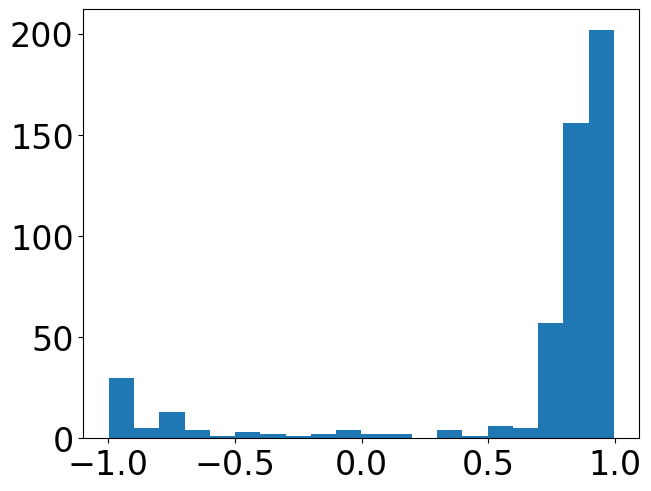

In [101]:
plt.hist(data['Cor'], bins=20);

Cor                    0.852128
Alpha                  1.941650
Beta                   6.510338
Gamma                  0.082756
Translation_rate      90.742062
Degradation_rate       0.001189
RNA_half_life          8.375782
Protein_half_life    582.797763
Name: 18, dtype: float64
18


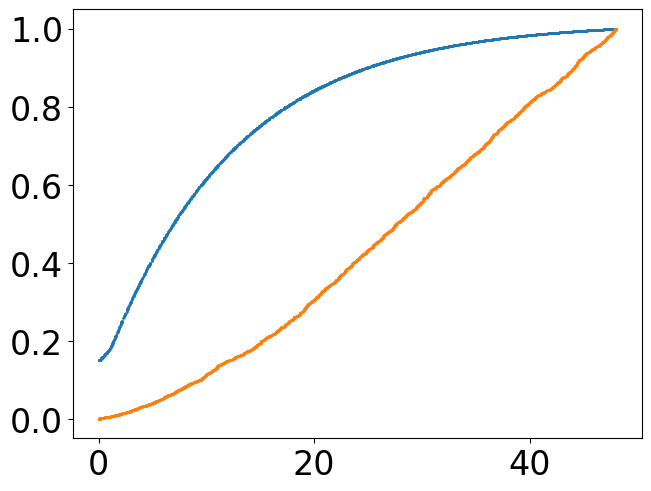

In [102]:
idx = 12
row = data.loc[data['Cor'] > .85].iloc[idx]
i = row.name  # This gives the actual index in the original DataFrame

print(row)
print(i)

y_i = Y[l*n:(l+1)*n, i, 1]/max(Y[l*n:(l+1)*n, i, 1])
p_i = P[l*n:(l+1)*n, i]/max(P[l*n:(l+1)*n, i])
plt.scatter(true_t[true_l == l], y_i, s=1)
plt.scatter(true_t[true_l == l], p_i, s=1)

Cor                  -0.923115
Alpha                 2.687896
Beta                  2.421122
Gamma                 0.080504
Translation_rate      6.255994
Degradation_rate      0.022888
RNA_half_life         8.610087
Protein_half_life    30.284562
Name: 34, dtype: float64
34


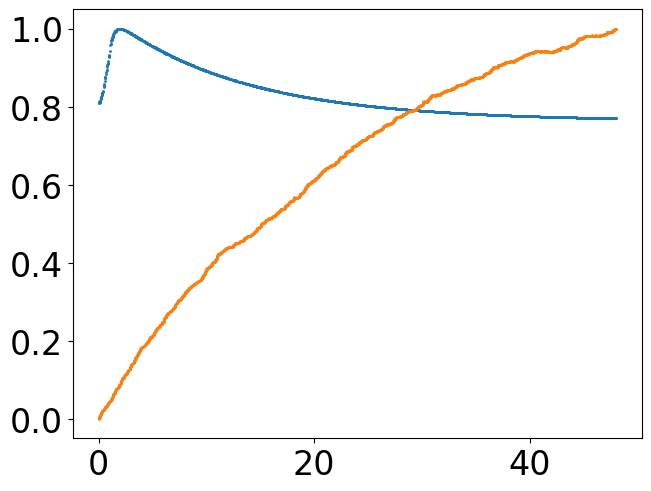

In [103]:
idx = 2
cor = 0

i = data.loc[data['Cor'] < cor].index[idx]
print(data.iloc[i])
print(i)
y_i = Y[l*n:(l+1)*n, i, 1]/max(Y[l*n:(l+1)*n, i, 1])
p_i = P[l*n:(l+1)*n, i]/max(P[l*n:(l+1)*n, i])
plt.scatter(true_t[true_l == l], y_i, s=1)
plt.scatter(true_t[true_l == l], p_i, s=1)

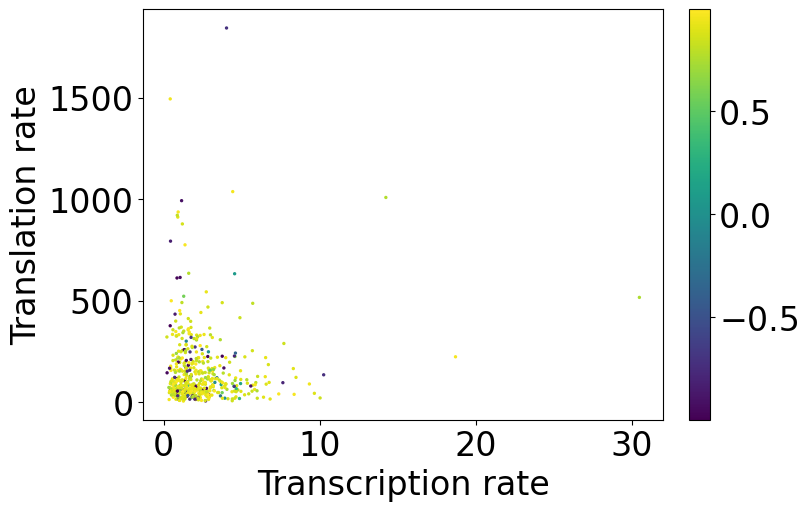

In [104]:
plt.figure(figsize=(8, 5))
plot = plt.scatter(data['Alpha'], data['Translation_rate'], c=data['Cor'], s=2);
plt.xlabel('Transcription rate');
plt.ylabel('Translation rate');
cbar = plt.colorbar(plot);
plt.show();

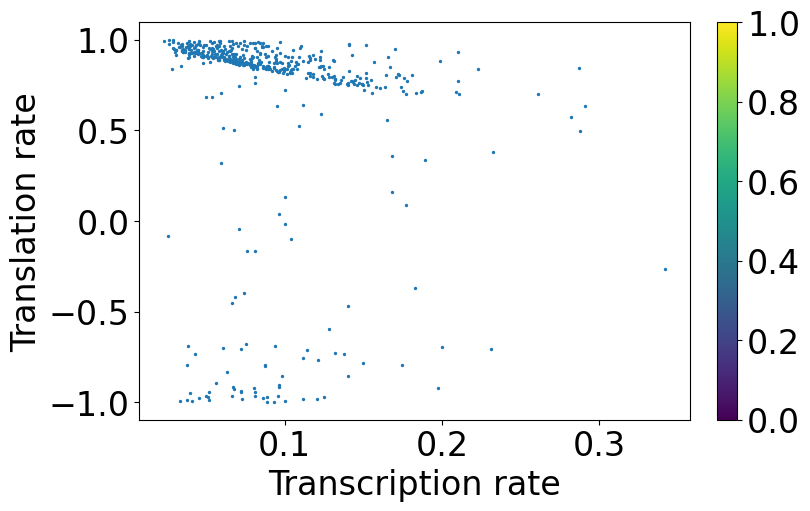

In [113]:
plt.figure(figsize=(8, 5))
plot = plt.scatter(data['Gamma'], data['Cor'], s=2);
plt.xlabel('Transcription rate');
plt.ylabel('Translation rate');
cbar = plt.colorbar(plot);
plt.show();

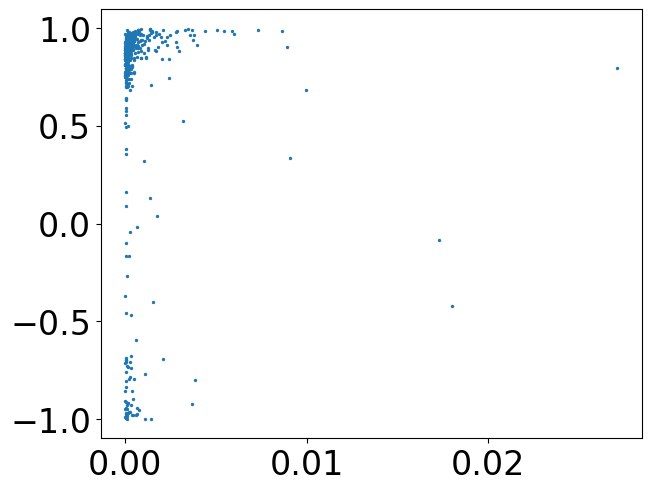

In [129]:
plot = plt.scatter(data['Degradation_rate']/data['Translation_rate'], data['Cor'], s=2);

In [127]:
np.corrcoef(data['Gamma']/data['Alpha'], data['Cor'])

array([[ 1.        , -0.05805969],
       [-0.05805969,  1.        ]])

In [114]:
np.corrcoef(data['Gamma'], data['Cor'])

array([[ 1.        , -0.12765584],
       [-0.12765584,  1.        ]])

In [ ]:
# from sklearn.linear_model import LinearRegression

# # Combine all predictors into one 2D array
# X = data[['Alpha', 'Beta', 'Gamma', 'Translation_rate', 'Degradation_rate']].values
# y = data['Cor'].values

# # Fit linear regression model
# model = LinearRegression()
# model.fit(X, y)

# # Output coefficients and R²
# print(f"Coefficients: {model.coef_}")
# print(f"Intercept: {model.intercept_}")
# print(f"R² score: {model.score(X, y)}")


Coefficients: [ 1.13001201e-02  8.78623973e-03 -1.41620883e+00 -2.72489284e-04
  4.14500878e-01]
Intercept: 0.7030762568411439
R² score: 0.033294319495715596
